In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/lfw.zip', 'r') as zip_ref:
    zip_ref.extractall('')

In [4]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from torchvision.utils import save_image
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import torch.optim as optim
import cv2
import numpy as np
import os, random,sys


# Build an Autoencoder for a human face dataset

We will use a dataset containig images of people and train an autoencoder on it.

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [5]:
path = '/content/lfw'

In [6]:
transform    = transforms.Compose([transforms.ToTensor()])
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)


This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [7]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")


MPS device not found.


torch.Size([250, 250, 3])


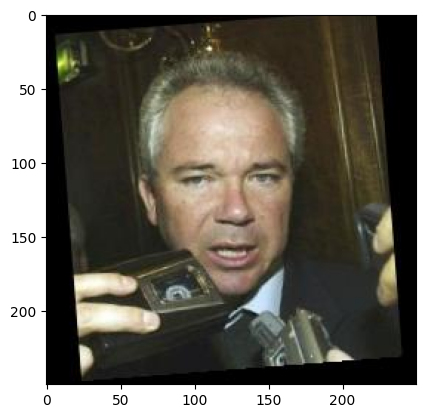

In [8]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

## Step 2
Each datapoint is an image. Get a sample of the data and print its dimensions and explain what each dimension means.

In [9]:
# Step 2: Get a sample of the data and print its dimensions
sample_image, sample_label = next(iter(dataloader))

# Dimensions of the sample image
print("Sample image shape:", sample_image.shape)
print("Sample Label:", sample_label)

# Explanation of dimensions
batch_size, channels, height, width = sample_image.shape
print("Batch size:", batch_size)
print("Number of channels (RGB):", channels)
print("Image height:", height)
print("Image width:", width)


Sample image shape: torch.Size([32, 3, 250, 250])
Sample Label: tensor([5732, 2120,  129, 4250, 3394, 2507, 3938,  992, 3127, 3669, 4210,  220,
         387, 4750, 2835, 5626, 2027,  602, 1679, 2846,  566, 1217, 1209, 2884,
        2481, 2555, 3118, 4878, 1213,  417, 2195, 4316])
Batch size: 32
Number of channels (RGB): 3
Image height: 250
Image width: 250


Batch size: This is the number of images in your batch. In your case, it's 32, as specified in your DataLoader (batch_size=32).

Number of channels (RGB): This is 3, as each image is in color and has three channels (Red, Green, Blue).

Image height: This is 250, which represents the number of pixels along the vertical axis of the image.

Image width: This is also 250, representing the number of pixels along the horizontal axis of the image.

So, the sample_image tensor has a shape of [32, 3, 250, 250], indicating a batch of 32 color images, each with dimensions 250x250 pixels.

# Step 3

Create a new pytorch model calss for your autoencoder. You can use Conv2d, MaxPool2d, BatchNorm2d, ConvTranspose2d and Linear Layers as as well as activation functions. Optionally, you can use UpSample, AveragePool2d and Interpolate2d as well.

**Create seperate functions for the encoder and decoder.**

In [10]:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()

        # Encoder
        self.encoder_layer = self.encoder()

        # Decoder
        self.decoder_layer = self.decoder()

    def encoder(self):
        return nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2)
        )

    def decoder(self):
        return nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        encoded_output = self.encoder_layer(x)
        decoded_output = self.decoder_layer(encoded_output)
        return decoded_output

## Step 4
Create an instance of the class, pass an image to the model, print the shape of the output of the **encoder** and the **decoder**. Check the dimensions and make sure your forward path is working properly.

In [11]:
# Instantiate the Autoencoder model
model = AE()

In [12]:
# Get a batch of images from the DataLoader
for images, _ in dataloader:
    # Check the shape of the output from the encoder and decoder
    output_of_encoder = model.encoder_layer(images)
    print(output_of_encoder.shape)

    output_of_decoder = model.decoder_layer(output_of_encoder)
    print(output_of_decoder.shape)

    forward_completed = model(images)
    print(forward_completed.shape)

    break  # Breaking the loop after processing the first batch

torch.Size([32, 128, 32, 32])
torch.Size([32, 3, 250, 250])
torch.Size([32, 3, 250, 250])


##  Step 5
Print total number of parameters in the model, explain what loss function you should use, create an optimizer for training

In [13]:
# Print the total number of parameters in the model
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters in the model: {total_params}")

# Optimizer
learning_rate = 0.001

Total number of parameters in the model: 336579


model.parameters() returns an iterator over all model parameters.

p.numel() gives the number of elements in each parameter.

In [14]:
# Optimizer
optim = optim.Adam(model.parameters(), lr=learning_rate)

In [15]:
# Loss function
loss_function = nn.MSELoss()

Loss Function: Autoencoders attempt to distill the most salient aspects of the input data (x) into a smaller latent space (z). From this latent space (Z), they attempt to rebuild the original image into new images (x_hat). (X -> Z -> Decoder -> X_hat -> Encoder)

The generated data should resemble the original data as much as possible, and the latent space should be as minimal as feasible, for an optimal AE. (Small latent space to reduce computational cost and increase AE efficiency).

Because it attempts to close the gap between the created data and the original data (or, in the case of images, the closest available pixel values), the MSE loss function is thus appropriate.

Since autoencoders are trained to recreate their input data, I chose to major in machine learning. The average squared difference between the input data and the reconstructed output is measured by the mean squared (MSE). The model is encouraged to generate reconstructions that closely resemble the original input data by minimizing the mean square error (MSE). Moreover, because MSE squares the value differences, it penalizes greater errors more severely.

##  Step 6
Write a training loop and start trainng the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [16]:
if not os.path.exists('./generated'):
    os.mkdir('./generated')

def to_img(x):
    x = x.view(x.size(0), 3, 250, 250)
    return x

In [17]:
for epoch in range(300):
    total_loss = 0
    for x,y in dataloader:
        # ===================forward=====================
        decoded_images = model.forward(x)
        loss = loss_function(decoded_images, x)

        # ===================backward====================

        optim.zero_grad()
        loss.backward()
        optim.step()
        total_loss += loss.data
        break;
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch+1, 300, total_loss))
    if epoch % 10 == 0:
        pic = to_img(decoded_images.cpu().data)
        save_image(pic, './generated/image_{}.png'.format(epoch))

epoch [1/300], loss:0.4631
epoch [2/300], loss:0.3229
epoch [3/300], loss:0.2510
epoch [4/300], loss:0.2008
epoch [5/300], loss:0.1599
epoch [6/300], loss:0.1274
epoch [7/300], loss:0.1159
epoch [8/300], loss:0.1016
epoch [9/300], loss:0.0844
epoch [10/300], loss:0.0788
epoch [11/300], loss:0.0768
epoch [12/300], loss:0.0582
epoch [13/300], loss:0.0568
epoch [14/300], loss:0.0509
epoch [15/300], loss:0.0419
epoch [16/300], loss:0.0403
epoch [17/300], loss:0.0395
epoch [18/300], loss:0.0378
epoch [19/300], loss:0.0380
epoch [20/300], loss:0.0335
epoch [21/300], loss:0.0316
epoch [22/300], loss:0.0303
epoch [23/300], loss:0.0288
epoch [24/300], loss:0.0314
epoch [25/300], loss:0.0265
epoch [26/300], loss:0.0264
epoch [27/300], loss:0.0249
epoch [28/300], loss:0.0278
epoch [29/300], loss:0.0231
epoch [30/300], loss:0.0272
epoch [31/300], loss:0.0238
epoch [32/300], loss:0.0221
epoch [33/300], loss:0.0248
epoch [34/300], loss:0.0227
epoch [35/300], loss:0.0235
epoch [36/300], loss:0.0204
e

What should I do if my loss doesn't go down?

To maximize the loss, I have attempted the following.

Modification of Learning Rate:

A learning rate that is too high could lead to instability, while a learning rate that is too low would slow down the process. I attempted to change the learning pace.

Model Intricacy:

For the dataset, the model may be either too simple or too sophisticated. I changed the number of units, added or removed layers, and modified the network structure to modify the design of the model. If the model is very complex or overfitting, simplify it.

Examining Specific Examples:

Anomalies or samples that are challenging to reconstruct may be the cause of some examples' excessive loss.I made an effort to examine specific cases with significant reconstructive loss. It may highlight trends, outliers, or problems with the data that the model finds difficult to understand.

Trial and error and debugging:

Other problems that are unique to our dataset or model design may exist. I made an effort to test out several optimizers, loss functions, architectures, and hyperparameters.

##  Step 7

Take a random image from the dataset and plot it against the reconstructed (encoded + decoded) image.

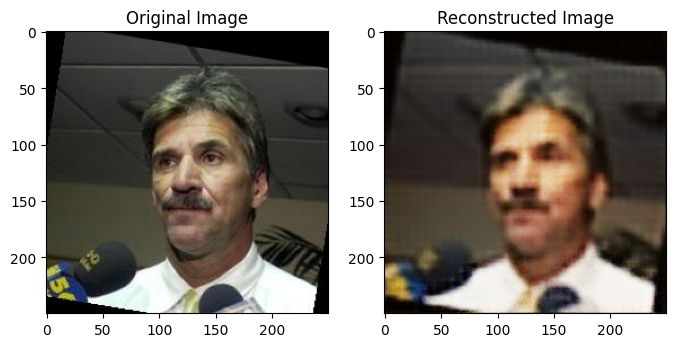

In [18]:
for images, _ in dataloader:
    original_image = images[21]

    # Forward pass through the model
    with torch.no_grad():
        reconstructed_image = model(original_image.unsqueeze(0))  # Add an extra dimension for batch size

    # Convert tensors to numpy arrays for visualization
    original_image_np = original_image.permute(1, 2, 0).cpu().numpy()
    reconstructed_image_np = reconstructed_image.squeeze(0).permute(1, 2, 0).cpu().numpy()

    # Plot the original and reconstructed images side by side
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(original_image_np)
    axes[0].set_title('Original Image')

    axes[1].imshow(reconstructed_image_np)
    axes[1].set_title('Reconstructed Image')

    break

# Show the plot outside the loop
plt.show()


##  Step 8

In step 7, add a small normaly distrubuted noise to the latent (hidden) representation of the input image and then decode it again. How is adding noise affecting the decoded image ?

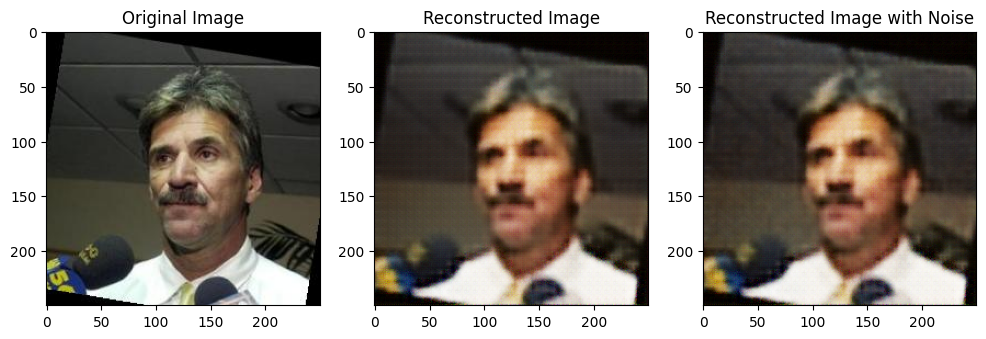

In [21]:
import torch.nn.functional as F

# Add a small normally distributed noise to the latent representation
latent_representation = model.encoder_layer(original_image.unsqueeze(0))
noise = torch.randn_like(latent_representation) * 0.1  # You can adjust the noise level
noisy_latent_representation = latent_representation + noise

# Decode the noised latent representation
with torch.no_grad():
    reconstructed_noisy_image = model.decoder_layer(noisy_latent_representation)

# Clamp pixel values to the valid range [0, 1]
reconstructed_noisy_image = torch.clamp(reconstructed_noisy_image, 0, 1)

# Convert tensors to numpy arrays for visualization
original_image_np = original_image.permute(1, 2, 0).cpu().numpy()
reconstructed_image_np = reconstructed_image.squeeze(0).permute(1, 2, 0).cpu().numpy()
reconstructed_noisy_image_np = reconstructed_noisy_image.squeeze(0).permute(1, 2, 0).cpu().numpy()

# Explicitly check and clamp pixel values
original_image_np = np.clip(original_image_np, 0, 1)
reconstructed_image_np = np.clip(reconstructed_image_np, 0, 1)
reconstructed_noisy_image_np = np.clip(reconstructed_noisy_image_np, 0, 1)

# Plot the original, reconstructed, and reconstructed with noise images side by side
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(original_image_np)
axes[0].set_title('Original Image')

axes[1].imshow(reconstructed_image_np)
axes[1].set_title('Reconstructed Image')

axes[2].imshow(reconstructed_noisy_image_np)
axes[2].set_title('Reconstructed Image with Noise')

plt.show()


incorporating noise with a normal distribution into the latent (hidden) representation.

=> An autoencoder's decoded image may change in a number of ways when noise is added to the latent (hidden) representation of an image.

=> To start, it can strengthen the decoder. The decoder is compelled to learn how to rebuild the original image by adding noise, even while there are minute perturbations in the latent representation. This may lessen the decoder's sensitivity to minute variations in the latent representation and enhance the decoded image's quality.

=> A second way to stop overfitting is to introduce noise. When a model learns to replicate the training data exactly yet performs poorly on unknown data, this is known as overfitting. The model is compelled to learn more generic properties of the data when noise is introduced to the latent representation, which might enhance the model's performance on unobserved data.

=> The impact of including noise into the latent representation, however, will vary based on the particular features of both the data and the noise. An excessive amount of noise might overpower the signal in the latent representation, deteriorating the quality of the decoded image or causing further distortion. On the other hand, if the noise is too tiny, it might not have a big impact on the resilience of the decoder or the generalization capability of the model.